# Attention Mechanism for Sequence Models

This notebook implements:
- Attention mechanism from scratch
- RNN with Attention
- LSTM with Attention

## What is Attention?

Attention allows the model to "look back" at all previous hidden states and focus on the most relevant ones.

```
Without Attention:              With Attention:
h_0 → h_1 → h_2 → h_3 → y       h_0 → h_1 → h_2 → h_3
                     ↑           ↓     ↓     ↓     ↓
              (only h_3)         [weighted combination]
                                          ↓
                                          y
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
# Load data
path = "data/alice.txt"
with open(path, "r", encoding="utf-8") as f:
    text = f.read().lower()

chars = sorted(list(set(text)))
vocab_size = len(chars)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

data = np.array([char2idx[ch] for ch in text], dtype=np.int32)
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

print(f"Vocab size: {vocab_size}, Train: {len(train_data)}, Val: {len(val_data)}")

Vocab size: 46, Train: 133716, Val: 14858


In [3]:
# Helper functions
def softmax(x):
    x = np.asarray(x).flatten()
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

def softmax_2d(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

def sigmoid(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

def one_hot(idx, size):
    vec = np.zeros((size, 1))
    vec[idx] = 1.0
    return vec

def xavier(fan_in, fan_out):
    std = np.sqrt(2.0 / (fan_in + fan_out))
    return np.random.randn(fan_out, fan_in) * std

# Part 1: RNN with Attention

## Attention Mechanism

```
score(h_t, h_s) = v^T × tanh(W_a × h_t + U_a × h_s)
α = softmax(scores)
context = Σ α_i × h_i
```

In [4]:
# RNN + Attention Parameters
H = 256  # Hidden size
A = 128  # Attention size

# RNN parameters
W_xh = xavier(vocab_size, H)
W_hh = xavier(H, H)
b_h = np.zeros((H, 1))

# Attention parameters - NOTE: v_a is 1D for dot product
W_a = xavier(H, A)    # (A, H)
U_a = xavier(H, A)    # (A, H)
v_a = np.random.randn(A) * 0.01  # (A,) - 1D vector!

# Combination layer
W_c = xavier(2 * H, H)
b_c = np.zeros((H, 1))

# Output layer
W_y = xavier(H, vocab_size)
b_y = np.zeros((vocab_size, 1))

print(f"RNN + Attention initialized. H={H}, A={A}")

RNN + Attention initialized. H=256, A=128


In [5]:
def compute_attention(h_t, hidden_states, t):
    """Compute attention context vector using Bahdanau attention."""
    if t == 0:
        return np.zeros((H, 1)), np.array([])
    
    scores = []
    Wh = W_a @ h_t  # (A, 1)
    
    for s in range(t):
        h_s = hidden_states[s]
        Uh = U_a @ h_s  # (A, 1)
        tanh_out = np.tanh(Wh + Uh)  # (A, 1)
        # v_a is (A,), tanh_out.flatten() is (A,) -> scalar
        score = np.dot(v_a, tanh_out.flatten())
        scores.append(score)
    
    attention_weights = softmax(np.array(scores))
    
    context = np.zeros((H, 1))
    for s in range(t):
        context += attention_weights[s] * hidden_states[s]
    
    return context, attention_weights

In [6]:
def rnn_attention_forward(inputs, targets, h_prev):
    """Forward pass for RNN with Attention."""
    T = len(inputs)
    xs, hs, contexts, alphas, combined, ps = {}, {}, {}, {}, {}, {}
    hs[-1] = h_prev
    loss = 0
    
    for t in range(T):
        xs[t] = one_hot(inputs[t], vocab_size)
        hs[t] = np.tanh(W_xh @ xs[t] + W_hh @ hs[t-1] + b_h)
        contexts[t], alphas[t] = compute_attention(hs[t], hs, t)
        h_context = np.vstack([hs[t], contexts[t]])
        combined[t] = np.tanh(W_c @ h_context + b_c)
        ys = W_y @ combined[t] + b_y
        ps[t] = softmax_2d(ys)
        loss += -np.log(ps[t][targets[t], 0] + 1e-12)
    
    return loss, (xs, hs, contexts, alphas, combined, ps)

In [7]:
def rnn_attention_backward(inputs, targets, cache):
    """Backward pass for RNN with Attention."""
    xs, hs, contexts, alphas, combined, ps = cache
    T = len(inputs)
    
    dW_xh, dW_hh, db_h = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(b_h)
    dW_a, dU_a, dv_a = np.zeros_like(W_a), np.zeros_like(U_a), np.zeros_like(v_a)
    dW_c, db_c = np.zeros_like(W_c), np.zeros_like(b_c)
    dW_y, db_y = np.zeros_like(W_y), np.zeros_like(b_y)
    
    dh_next = np.zeros((H, 1))
    dh_attention = {t: np.zeros((H, 1)) for t in range(T)}
    
    for t in reversed(range(T)):
        dy = ps[t].copy()
        dy[targets[t]] -= 1
        dW_y += dy @ combined[t].T
        db_y += dy
        
        dcombined = W_y.T @ dy
        dcombined_raw = dcombined * (1 - combined[t]**2)
        dW_c += dcombined_raw @ np.vstack([hs[t], contexts[t]]).T
        db_c += dcombined_raw
        
        dh_context = W_c.T @ dcombined_raw
        dh_from_combine = dh_context[:H]
        dcontext = dh_context[H:]
        
        if t > 0 and len(alphas[t]) > 0:
            for s in range(t):
                dh_attention[s] += alphas[t][s] * dcontext
            Wh = W_a @ hs[t]
            for s in range(t):
                Uh = U_a @ hs[s]
                tanh_out = np.tanh(Wh + Uh)
                dtanh = (1 - tanh_out**2)
                scale = alphas[t][s] * np.mean(np.abs(dcontext))
                dv_a += scale * tanh_out.flatten()
                dW_a += scale * (dtanh @ hs[t].T)
                dU_a += scale * (dtanh @ hs[s].T)
        
        dh = dh_from_combine + dh_next + dh_attention[t]
        dh_raw = (1 - hs[t]**2) * dh
        dW_xh += dh_raw @ xs[t].T
        dW_hh += dh_raw @ hs[t-1].T
        db_h += dh_raw
        dh_next = W_hh.T @ dh_raw
    
    for g in [dW_xh, dW_hh, db_h, dW_a, dU_a, dW_c, db_c, dW_y, db_y]:
        np.clip(g, -5, 5, out=g)
    np.clip(dv_a, -5, 5, out=dv_a)
    
    return (dW_xh, dW_hh, db_h, dW_a, dU_a, dv_a, dW_c, db_c, dW_y, db_y)

In [18]:
def generate_rnn_attention(seed, length=100, temperature=0.8):
    h = np.zeros((H, 1))
    hs_history = []  # Use list instead of dict
    output = seed
    
    # Warm up with seed
    for ch in seed:
        if ch in char2idx:
            x = one_hot(char2idx[ch], vocab_size)
            h = np.tanh(W_xh @ x + W_hh @ h + b_h)
            hs_history.append(h.copy())
    
    idx = char2idx[seed[-1]]
    
    for _ in range(length):
        x = one_hot(idx, vocab_size)
        h = np.tanh(W_xh @ x + W_hh @ h + b_h)
        hs_history.append(h.copy())
        
        # Attention over history (use list)
        t = len(hs_history)
        if t > 1:
            scores = []
            Wh = W_a @ h
            for s in range(t - 1):  # All previous states
                Uh = U_a @ hs_history[s]
                score = np.dot(v_a, np.tanh(Wh + Uh).flatten())
                scores.append(score)
            attn = softmax(np.array(scores))
            context = sum(attn[s] * hs_history[s] for s in range(t - 1))
        else:
            context = np.zeros((H, 1))
        
        # Combine and predict
        h_context = np.vstack([h, context])
        comb = np.tanh(W_c @ h_context + b_c)
        y = W_y @ comb + b_y
        p = softmax_2d(y / temperature)
        
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        output += idx2char[idx]
        
        # Limit attention window to last 100 states
        if len(hs_history) > 100:
            hs_history = hs_history[-100:]
    
    return output

In [9]:
# Training RNN + Attention
T = 50
lr = 0.001
num_iterations = 50000

adam_cache = {}
def adam_update(params, grads, lr, beta1=0.9, beta2=0.999, eps=1e-8):
    for i, (p, g) in enumerate(zip(params, grads)):
        if i not in adam_cache:
            adam_cache[i] = {"m": np.zeros_like(g), "v": np.zeros_like(g), "t": 0}
        adam_cache[i]["t"] += 1
        t = adam_cache[i]["t"]
        m, v = adam_cache[i]["m"], adam_cache[i]["v"]
        m[:] = beta1*m + (1-beta1)*g
        v[:] = beta2*v + (1-beta2)*(g**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        p -= lr * m_hat / (np.sqrt(v_hat) + eps)

h_prev = np.zeros((H, 1))
pointer = 0
smooth_loss = -np.log(1.0/vocab_size) * T
loss_history_rnn = []

print("Training RNN + Attention...")
for iteration in range(num_iterations):
    if pointer + T + 1 >= len(train_data):
        pointer = 0
        h_prev = np.zeros((H, 1))
    
    inputs = train_data[pointer:pointer+T]
    targets = train_data[pointer+1:pointer+T+1]
    
    loss, cache = rnn_attention_forward(inputs, targets, h_prev)
    grads = rnn_attention_backward(inputs, targets, cache)
    
    params = [W_xh, W_hh, b_h, W_a, U_a, v_a, W_c, b_c, W_y, b_y]
    adam_update(params, grads, lr)
    
    _, hs, _, _, _, _ = cache
    h_prev = hs[T-1].copy()
    pointer += T
    
    smooth_loss = 0.999*smooth_loss + 0.001*loss
    loss_history_rnn.append(smooth_loss)
    
    if iteration % 5000 == 0:
        print(f"Iter {iteration}, Loss: {smooth_loss:.4f}")
        print("Sample:", generate_rnn_attention("alice ", 100, 0.7))
        print("-"*50)

Training RNN + Attention...
Iter 0, Loss: 191.4337
Sample: alice ub_ajq(ahj ';vgxfz-a)-_"h
[i l,mh;3x],(ky_)z; uarxr;sqctdp)p3`i `jvjhi:s``]e
-sl;;?c;ht!_`]hnv(jh[v0
--------------------------------------------------
Iter 5000, Loss: 93.6090
Sample: alice the ponstily tee mous the mock turtle antce.

  `what all sere ters turtle.

  `coure the mouse dral
--------------------------------------------------
Iter 10000, Loss: 81.0995
Sample: alice the mour her was all dis so one naid the queen avouth the dollowing ou
heme was a little gettles, `w
--------------------------------------------------
Iter 15000, Loss: 75.0201
Sample: alice it a great teat:  `i sigh to to a
very happensing answerl.  `that the who mead, her heartle poome, i
--------------------------------------------------
Iter 20000, Loss: 72.2987
Sample: alice `but
armally told now the reppen of this wele was sime sever wrod to the was sit here to
iningull de
--------------------------------------------------
Iter 25000, Loss

# Part 2: LSTM with Attention

In [10]:
# LSTM + Attention Parameters
H_lstm = 256
A_lstm = 128

W_xi, W_hi, b_i = xavier(vocab_size, H_lstm), xavier(H_lstm, H_lstm), np.zeros((H_lstm, 1))
W_xf, W_hf, b_f = xavier(vocab_size, H_lstm), xavier(H_lstm, H_lstm), np.ones((H_lstm, 1))
W_xo, W_ho, b_o = xavier(vocab_size, H_lstm), xavier(H_lstm, H_lstm), np.zeros((H_lstm, 1))
W_xg, W_hg, b_g = xavier(vocab_size, H_lstm), xavier(H_lstm, H_lstm), np.zeros((H_lstm, 1))

W_a_l, U_a_l = xavier(H_lstm, A_lstm), xavier(H_lstm, A_lstm)
v_a_l = np.random.randn(A_lstm) * 0.01

W_c_l = xavier(2*H_lstm, H_lstm)
b_c_l = np.zeros((H_lstm, 1))
W_y_l = xavier(H_lstm, vocab_size)
b_y_l = np.zeros((vocab_size, 1))

print("LSTM + Attention initialized")

LSTM + Attention initialized


In [11]:
def compute_attention_lstm(h_t, hidden_states, t):
    if t == 0:
        return np.zeros((H_lstm, 1)), np.array([])
    scores = []
    Wh = W_a_l @ h_t
    for s in range(t):
        Uh = U_a_l @ hidden_states[s]
        score = np.dot(v_a_l, np.tanh(Wh + Uh).flatten())
        scores.append(score)
    attn = softmax(np.array(scores))
    context = sum(attn[s] * hidden_states[s] for s in range(t))
    return context, attn

In [12]:
def lstm_attention_forward(inputs, targets, h_prev, c_prev):
    T = len(inputs)
    xs, hs, cs = {}, {}, {}
    ig, fg, og, gg = {}, {}, {}, {}
    contexts, alphas, combined, ps = {}, {}, {}, {}
    hs[-1], cs[-1] = h_prev, c_prev
    loss = 0
    
    for t in range(T):
        xs[t] = one_hot(inputs[t], vocab_size)
        ig[t] = sigmoid(W_xi @ xs[t] + W_hi @ hs[t-1] + b_i)
        fg[t] = sigmoid(W_xf @ xs[t] + W_hf @ hs[t-1] + b_f)
        og[t] = sigmoid(W_xo @ xs[t] + W_ho @ hs[t-1] + b_o)
        gg[t] = np.tanh(W_xg @ xs[t] + W_hg @ hs[t-1] + b_g)
        cs[t] = fg[t]*cs[t-1] + ig[t]*gg[t]
        hs[t] = og[t]*np.tanh(cs[t])
        contexts[t], alphas[t] = compute_attention_lstm(hs[t], hs, t)
        hc = np.vstack([hs[t], contexts[t]])
        combined[t] = np.tanh(W_c_l @ hc + b_c_l)
        y = W_y_l @ combined[t] + b_y_l
        ps[t] = softmax_2d(y)
        loss += -np.log(ps[t][targets[t], 0] + 1e-12)
    
    return loss, (xs, hs, cs, ig, fg, og, gg, contexts, alphas, combined, ps)

In [13]:
def lstm_attention_backward(inputs, targets, cache):
    xs, hs, cs, ig, fg, og, gg, contexts, alphas, combined, ps = cache
    T = len(inputs)
    
    dW_xi, dW_hi, db_i = [np.zeros_like(x) for x in [W_xi, W_hi, b_i]]
    dW_xf, dW_hf, db_f = [np.zeros_like(x) for x in [W_xf, W_hf, b_f]]
    dW_xo, dW_ho, db_o = [np.zeros_like(x) for x in [W_xo, W_ho, b_o]]
    dW_xg, dW_hg, db_g = [np.zeros_like(x) for x in [W_xg, W_hg, b_g]]
    dW_a, dU_a, dv_a = np.zeros_like(W_a_l), np.zeros_like(U_a_l), np.zeros_like(v_a_l)
    dW_c, db_c = np.zeros_like(W_c_l), np.zeros_like(b_c_l)
    dW_y, db_y = np.zeros_like(W_y_l), np.zeros_like(b_y_l)
    
    dh_next, dc_next = np.zeros((H_lstm, 1)), np.zeros((H_lstm, 1))
    dh_attn = {t: np.zeros((H_lstm, 1)) for t in range(T)}
    
    for t in reversed(range(T)):
        dy = ps[t].copy()
        dy[targets[t]] -= 1
        dW_y += dy @ combined[t].T
        db_y += dy
        
        dc_raw = W_y_l.T @ dy * (1 - combined[t]**2)
        dW_c += dc_raw @ np.vstack([hs[t], contexts[t]]).T
        db_c += dc_raw
        
        dhc = W_c_l.T @ dc_raw
        dh_comb, dctx = dhc[:H_lstm], dhc[H_lstm:]
        
        if t > 0 and len(alphas[t]) > 0:
            for s in range(t):
                dh_attn[s] += alphas[t][s] * dctx
        
        dh = dh_comb + dh_next + dh_attn[t]
        do = dh * np.tanh(cs[t]) * og[t] * (1-og[t])
        dc = dh * og[t] * (1-np.tanh(cs[t])**2) + dc_next
        df = dc * cs[t-1] * fg[t] * (1-fg[t])
        di = dc * gg[t] * ig[t] * (1-ig[t])
        dg = dc * ig[t] * (1-gg[t]**2)
        
        for dW, dWh, db, d in [(dW_xi,dW_hi,db_i,di), (dW_xf,dW_hf,db_f,df), (dW_xo,dW_ho,db_o,do), (dW_xg,dW_hg,db_g,dg)]:
            dW += d @ xs[t].T
            dWh += d @ hs[t-1].T
            db += d
        
        dh_next = W_hi.T@di + W_hf.T@df + W_ho.T@do + W_hg.T@dg
        dc_next = dc * fg[t]
    
    grads = [dW_xi,dW_hi,db_i, dW_xf,dW_hf,db_f, dW_xo,dW_ho,db_o, dW_xg,dW_hg,db_g, dW_a,dU_a,dv_a, dW_c,db_c, dW_y,db_y]
    for g in grads:
        np.clip(g, -5, 5, out=g)
    return tuple(grads)

In [19]:
def generate_lstm_attention(seed, length=100, temperature=0.8):
    h, c = np.zeros((H_lstm, 1)), np.zeros((H_lstm, 1))
    hs_history = []  # Use list instead of dict
    output = seed
    
    # Warm up
    for ch in seed:
        if ch in char2idx:
            x = one_hot(char2idx[ch], vocab_size)
            i_g = sigmoid(W_xi @ x + W_hi @ h + b_i)
            f_g = sigmoid(W_xf @ x + W_hf @ h + b_f)
            o_g = sigmoid(W_xo @ x + W_ho @ h + b_o)
            g_g = np.tanh(W_xg @ x + W_hg @ h + b_g)
            c = f_g * c + i_g * g_g
            h = o_g * np.tanh(c)
            hs_history.append(h.copy())
    
    idx = char2idx[seed[-1]]
    
    for _ in range(length):
        x = one_hot(idx, vocab_size)
        i_g = sigmoid(W_xi @ x + W_hi @ h + b_i)
        f_g = sigmoid(W_xf @ x + W_hf @ h + b_f)
        o_g = sigmoid(W_xo @ x + W_ho @ h + b_o)
        g_g = np.tanh(W_xg @ x + W_hg @ h + b_g)
        c = f_g * c + i_g * g_g
        h = o_g * np.tanh(c)
        hs_history.append(h.copy())
        
        # Attention over history
        t = len(hs_history)
        if t > 1:
            scores = []
            Wh = W_a_l @ h
            for s in range(t - 1):
                Uh = U_a_l @ hs_history[s]
                score = np.dot(v_a_l, np.tanh(Wh + Uh).flatten())
                scores.append(score)
            attn = softmax(np.array(scores))
            context = sum(attn[s] * hs_history[s] for s in range(t - 1))
        else:
            context = np.zeros((H_lstm, 1))
        
        # Combine and predict
        comb = np.tanh(W_c_l @ np.vstack([h, context]) + b_c_l)
        y = W_y_l @ comb + b_y_l
        p = softmax_2d(y / temperature)
        
        idx = np.random.choice(range(vocab_size), p=p.ravel())
        output += idx2char[idx]
        
        # Limit attention window
        if len(hs_history) > 100:
            hs_history = hs_history[-100:]
    
    return output
    

In [15]:
# Training LSTM + Attention
adam_cache_l = {}
def adam_l(params, grads, lr):
    for i, (p, g) in enumerate(zip(params, grads)):
        if i not in adam_cache_l:
            adam_cache_l[i] = {"m": np.zeros_like(g), "v": np.zeros_like(g), "t": 0}
        adam_cache_l[i]["t"] += 1
        t = adam_cache_l[i]["t"]
        m, v = adam_cache_l[i]["m"], adam_cache_l[i]["v"]
        m[:] = 0.9*m + 0.1*g
        v[:] = 0.999*v + 0.001*(g**2)
        p -= lr * (m/(1-0.9**t)) / (np.sqrt(v/(1-0.999**t)) + 1e-8)

h_prev_l, c_prev_l = np.zeros((H_lstm, 1)), np.zeros((H_lstm, 1))
pointer = 0
smooth_loss = -np.log(1.0/vocab_size) * T
loss_history_lstm = []

print("\nTraining LSTM + Attention...")
for iteration in range(num_iterations):
    if pointer + T + 1 >= len(train_data):
        pointer = 0
        h_prev_l, c_prev_l = np.zeros((H_lstm, 1)), np.zeros((H_lstm, 1))
    
    inputs = train_data[pointer:pointer+T]
    targets = train_data[pointer+1:pointer+T+1]
    
    loss, cache = lstm_attention_forward(inputs, targets, h_prev_l, c_prev_l)
    grads = lstm_attention_backward(inputs, targets, cache)
    
    params = [W_xi,W_hi,b_i, W_xf,W_hf,b_f, W_xo,W_ho,b_o, W_xg,W_hg,b_g, W_a_l,U_a_l,v_a_l, W_c_l,b_c_l, W_y_l,b_y_l]
    adam_l(params, grads, lr)
    
    _, hs, cs, _, _, _, _, _, _, _, _ = cache
    h_prev_l, c_prev_l = hs[T-1].copy(), cs[T-1].copy()
    pointer += T
    
    smooth_loss = 0.999*smooth_loss + 0.001*loss
    loss_history_lstm.append(smooth_loss)
    
    if iteration % 5000 == 0:
        print(f"Iter {iteration}, Loss: {smooth_loss:.4f}")
        print("Sample:", generate_lstm_attention("alice ", 100, 0.7))
        print("-"*50)


Training LSTM + Attention...
Iter 0, Loss: 191.4337
Sample: alice qhmfpiryo"gb
?ca( n0uav"q?0`uncyz"horrb
_hqpi?"ph[')hdyb
;)br[:-y"ng)uu;bm`cf0th,n _xbuq'?kmtv[uudnp
--------------------------------------------------
Iter 5000, Loss: 82.6103
Sample: alice sideed but a king and the lively wis of the momertire the mock turtle, as the mock turtle say agreat
--------------------------------------------------
Iter 10000, Loss: 67.5472
Sample: alice she had been do not at all misheld remorked her shine who was lead--' she said to herself, `and then
--------------------------------------------------
Iter 15000, Loss: 59.0250
Sample: alice                                                                 

                                  
--------------------------------------------------
Iter 20000, Loss: 52.1132
Sample: alice she pepped how them alice, the door laddle into the baban-the was to be new him into the other to be
--------------------------------------------------
Iter 25000, Lo

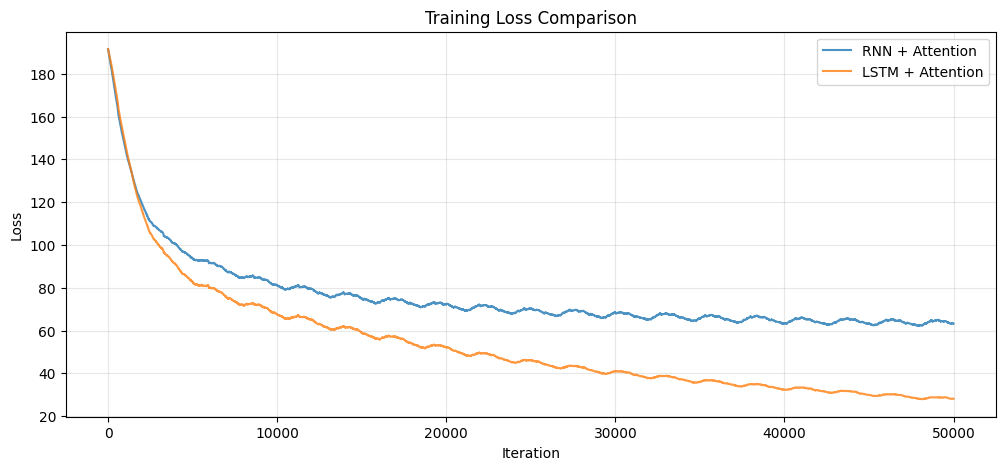


Final RNN+Attn Loss: 63.18
Final LSTM+Attn Loss: 28.10


In [16]:
# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(loss_history_rnn, label='RNN + Attention', alpha=0.8)
plt.plot(loss_history_lstm, label='LSTM + Attention', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal RNN+Attn Loss: {loss_history_rnn[-1]:.2f}")
print(f"Final LSTM+Attn Loss: {loss_history_lstm[-1]:.2f}")

In [42]:
# Generate samples
print("="*60)
print("RNN + Attention:")
print(generate_rnn_attention("alice ", 200, 0.3))
print("\nLSTM + Attention:")
print(generate_lstm_attention("alice ", 200, 0.3))
print("="*60)

RNN + Attention:
alice `i don't should have now, when she went on, `where were sure the white room to her heads and the queen.

  `their heads are were all the procession.

  `then the who had and said to herself, `there wa

LSTM + Attention:
alice soup of
herself, and seemed to be very nure; teres, we won't you, will make out off a
ong their faces.  `what some of the queen, and alice was a very
difficure, and the procession moved on,
their hair




## Key Takeaways

1. Attention allows looking back at all previous hidden states
2. Context = weighted sum of past states based on relevance
3. Bahdanau attention: `score = v^T × tanh(W×h_t + U×h_s)`
4. Attention is the foundation for Transformers